# Print probabilities from results

In [17]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.aqua.components.optimizers import GSLS, L_BFGS_B, SLSQP, TNC, CRS, DIRECT_L, DIRECT_L_RAND, ESCH, ISRES
import math
import random
import numpy as np
from numpy import pi
import itertools
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches as mpatches

In [18]:
def load_results_from_file(name ):
    with open('results/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_results_to_disk(obj, name ):
    with open('results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def get_max_result(first, second):
    Max = first
    for ind in range(len(MAX['probabilities'])):
        if Max['probabilities'][ind] < second['probabilities'][ind]:
            Max['best_algorithm'][ind] = second['best_algorithm'][ind]
            Max['probabilities'][ind] = second['probabilities'][ind]
            Max['configurations'][ind] = second['configurations'][ind]
    return(Max)

In [19]:
""" Load results from a file """
result1 = load_results_from_file(name='20210331_results_Entangled_clons')
#result90 = load_results_from_file(name='20210331_CRS_results_Entangled_clon8')

In [20]:
""" Mix result files """
MAX = result1
#MAX =  get_max_result(result1, result90)
result1 = MAX

In [21]:
""" Save mixed results to a file """
#save_results_to_disk(result1, name='20210331_results_Entangled_clons')

' Save mixed results to a file '

# From simulation results loaded previouly extract probabilities

Plot the probabilities array from simulations

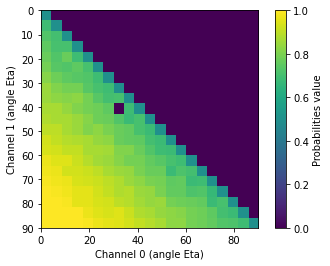

In [22]:
X1 = []
for eta_pair in result1['lambda_pairs']:
    X1.append(int(np.degrees(np.arcsin(np.sqrt(eta_pair[1])))))
    X1.append(int(np.degrees(np.arcsin(np.sqrt(eta_pair[0])))))
X1 = sorted(list(dict.fromkeys(X1)))
lenx1 = len(X1)
probs1 = np.zeros((lenx1,lenx1))
values1 = list(result1.values())
for ind_prob in range(len(values1[2])):
    ind_0 = X1.index(int(np.degrees(np.arcsin(np.sqrt(result1['lambda_pairs'][ind_prob][0])))))
    ind_1 = X1.index(int(np.degrees(np.arcsin(np.sqrt(result1['lambda_pairs'][ind_prob][1])))))
    probs1[ind_1, ind_0]= values1[2][ind_prob]
for i in range(len(X1)):
    probs1[i, i]= 0.5 

fig = plt.figure('Probabilities from simulation')
ax1 = fig.add_subplot(111)
im = ax1.imshow(probs1, cmap='viridis', extent =(0, 90, 90, 0), vmin=0, vmax=1)
cb = plt.colorbar(im, label = 'Probabilities value')
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

plt.show()

This graph shows the algorithm which provided in simulation time the higher probability result for the lambda pair simulated.


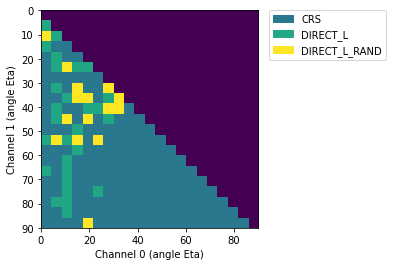

In [23]:
X1 = []
for eta_pair in result1['lambda_pairs']:
    X1.append(int(np.degrees(np.arcsin(np.sqrt(eta_pair[1])))))
    X1.append(int(np.degrees(np.arcsin(np.sqrt(eta_pair[0])))))
X1 = sorted(list(dict.fromkeys(X1)))
lenx1 = len(X1)
Optim1 = np.zeros((lenx1,lenx1))
values1 = list(result1.values())
for ind_prob in range(len(values1[1])):
    ind_0 = X1.index(int(np.degrees(np.arcsin(np.sqrt(result1['lambda_pairs'][ind_prob][0])))))
    ind_1 = X1.index(int(np.degrees(np.arcsin(np.sqrt(result1['lambda_pairs'][ind_prob][1])))))
    if values1[1][ind_prob] == 'CRS':
        Opt = 0.2
    elif values1[1][ind_prob] == 'DIRECT_L':
        Opt = 0.3
    else:
        Opt = 0.5
    Optim1[ind_1, ind_0]= Opt


fig = plt.figure('Optimization algorithm contribution in simulation')
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

values = [0.2, 0.3, 0.5]
Opt = ['CRS', 'DIRECT_L', 'DIRECT_L_RAND']
im = plt.imshow(Optim1, interpolation='none', extent =(0, 90, 90, 0))
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=Opt[i]) for i in range(len(Opt)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid(False)


plt.show()

In [24]:
def get_combinations_two_etas_without_repeats(input_list_lambda):
    """ from a given list of attenuations (lambdas) create a 
        list of all combinatorial pairs of possible lambdas
        without repeats (order does not matter).
        For us it is the same testing first lambda 0.1 and second lambda 0.2 
        than first lambda 0.2 and second lambda 0.1
    """
    list_lambda = input_list_lambda
     # when there is only one element, we add the same element
    if len(list_lambda) == 1:
        list_lambda.append(list_lambda[0])
    # get combinations of two lambdas without repeats
    return list(itertools.combinations(list_lambda, 2))

Here a result is computed to be operated in the same way that info from simulations.

In [25]:
# create the channels to be used
# from 0 to pi/2 in steps of 0.1, and adding the 1 as the last value
#lambdas = np.append(np.arange(0, 1, 0.05), 1)
#etas = np.arcsin(np.sqrt(lambdas))
etas = np.append(np.arange(0, pi/2, pi/2/20), pi/2)
two_pair_etas = get_combinations_two_etas_without_repeats(etas)
    
probabilities = []
configurations = []
improvements = []
best_algorithm = ['THEORY']

#program_start_time = time.time()
print("Starting the execution")

for eta_pair in two_pair_etas:
    GLOBAL_LAMBDA0=eta_pair[1]
    GLOBAL_LAMBDA1=eta_pair[0]
    Gamma = np.cos(GLOBAL_LAMBDA1) + np.cos(GLOBAL_LAMBDA0)
    Y_= (Gamma-1)/(Gamma-2)
    if Y_ > 0:
        best_probability = 1/4*(np.cos(GLOBAL_LAMBDA1) - np.cos(GLOBAL_LAMBDA0))*((1 - Y_)*Gamma + np.sqrt((1 - Y_)*(4*Y_ + (1 - Y_)*Gamma*Gamma)))+1/2
        improvement = 1/4*(np.cos(GLOBAL_LAMBDA1) - np.cos(GLOBAL_LAMBDA0))*((1 - Y_)*Gamma + np.sqrt((1 - Y_)*(4*Y_ + (1 - Y_)*Gamma*Gamma))) - 1/2*Gamma*(np.cos(GLOBAL_LAMBDA1) - np.cos(GLOBAL_LAMBDA0))
    else:
        best_probability = 1/2*Gamma*(np.cos(GLOBAL_LAMBDA1) - np.cos(GLOBAL_LAMBDA0))+1/2
        improvement = 0
    best_configuration = max(0, Y_)
    probabilities.append(best_probability)
    configurations.append(best_configuration)
    improvements.append(improvement)
    best_algorithm.append('THEORY')

print(f'Total pair of etas calculated: {len(two_pair_etas)}')

theoric_result = {
    "eta_pairs": two_pair_etas,
    "best_algorithm": best_algorithm,
    "probabilities": probabilities,
    "configurations": configurations,
    "improvements": improvements
}

Starting the execution
Total pair of etas calculated: 210


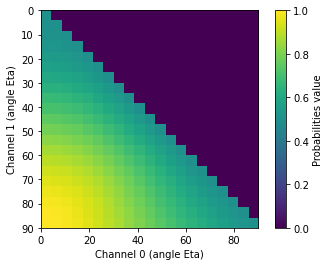

In [26]:
Ref = []
for eta_pair in theoric_result['eta_pairs']:
    Ref.append((eta_pair[1]))
    Ref.append((eta_pair[0]))
Ref = sorted(list(dict.fromkeys(Ref)))
lenRef = len(Ref)
probsRef = np.zeros((lenRef,lenRef))
valuesRef = list(theoric_result.values())
for ind_prob in range(len(valuesRef[2])):
    ind_0 = Ref.index(theoric_result['eta_pairs'][ind_prob][0])
    ind_1 = Ref.index(theoric_result['eta_pairs'][ind_prob][1])
    probsRef[ind_1, ind_0]= valuesRef[2][ind_prob]
for i in range(len(Ref)):
    probsRef[i, i]= 0.5   


fig = plt.figure('Probabilities from simulation')
ax1 = fig.add_subplot(111)
im = ax1.imshow(probsRef, cmap='viridis', extent =(0, 90, 90, 0))
cb = plt.colorbar(im, label = 'Probabilities value')
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

plt.show()

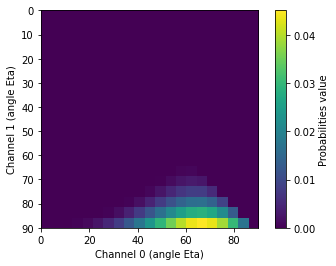

In [27]:
Ref = []
for eta_pair in theoric_result['eta_pairs']:
    Ref.append((eta_pair[1]))
    Ref.append((eta_pair[0]))
Ref = sorted(list(dict.fromkeys(Ref)))
lenRef = len(Ref)
ImprobsRef = np.zeros((lenRef,lenRef))
valuesRef = list(theoric_result.values())
for ind_prob in range(len(valuesRef[4])):
    ind_0 = Ref.index(theoric_result['eta_pairs'][ind_prob][0])
    ind_1 = Ref.index(theoric_result['eta_pairs'][ind_prob][1])
    ImprobsRef[ind_1, ind_0]= valuesRef[4][ind_prob]
#for i in range(len(Ref)):
#    probsRef[i, i]= 0.5   


fig = plt.figure('Probabilities from simulation')
ax1 = fig.add_subplot(111)
im = ax1.imshow(ImprobsRef, cmap='viridis', extent =(0, 90, 90, 0))
cb = plt.colorbar(im, label = 'Probabilities value')
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

plt.show()

# Compare probabilities from simulations against the theoric ones from paper
 ## Simulation 1 vs theory in absolute value

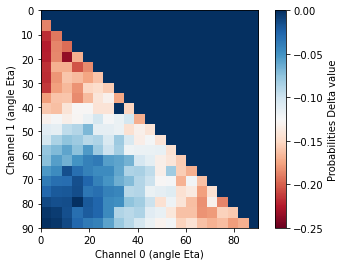

In [28]:
Delta_prob1= probsRef - probs1

fig = plt.figure('Difference in Probabilities (simulation vs. theory')
ax1 = fig.add_subplot(111)
im = ax1.imshow(Delta_prob1, cmap='RdBu', extent =(0, 90, 90, 0), vmin=-0.25, vmax=0)
cb = plt.colorbar(im, label = 'Probabilities Delta value')
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

plt.show()


 ## Simulation 1 vs theory in percentage

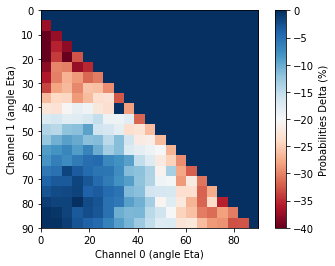

In [29]:
Total_col, Total_row = Delta_prob1.shape
col=Total_col
Delta_Pc_prob1= np.zeros((Total_col,Total_row))
while col > 0:
    row = Total_row
    while row > 0:
        if probsRef[row-1, col-1] == 0:
            if Delta_prob1[row-1, col-1] == 0:
                Delta_Pc_prob1[row-1, col-1]= 0
            else:
                Delta_Pc_prob1[row-1, col-1]= 10000
        else:
            Delta_Pc_prob1[row-1, col-1] = 100*Delta_prob1[row-1, col-1]/probsRef[row-1, col-1]
        row = row - 1
    col = col - 1

fig = plt.figure('Deviation in % from theoric probability (simulation vs. theory')
ax1 = fig.add_subplot(111)
im = ax1.imshow(Delta_Pc_prob1, cmap='RdBu', extent =(0, 90, 90, 0), vmin=-40, vmax=0)
cb = plt.colorbar(im, label = 'Probabilities Delta (%)')
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

plt.show()

# Input state obtained from simulations vs Theory
## Amplitude |1> from 1st simulation

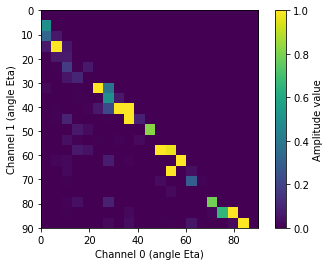

In [30]:
X1 = []
for eta_pair in result1['lambda_pairs']:
    X1.append(int(np.degrees(np.arcsin(np.sqrt(eta_pair[1])))))
    X1.append(int(np.degrees(np.arcsin(np.sqrt(eta_pair[0])))))
X1 = sorted(list(dict.fromkeys(X1)))
lenx1 = len(X1)
amp1 = np.zeros((lenx1,lenx1))
values1 = list(result1.values())
for ind_prob in range(len(values1[2])):
    ind_0 = X1.index(int(np.degrees(np.arcsin(np.sqrt(result1['lambda_pairs'][ind_prob][0])))))
    ind_1 = X1.index(int(np.degrees(np.arcsin(np.sqrt(result1['lambda_pairs'][ind_prob][1])))))
    amp1[ind_1, ind_0]= np.cos(values1[3][ind_prob][0])*np.cos(values1[3][ind_prob][0])
for i in range(len(X1)):
    probs1[i, i]= 0 

fig = plt.figure('Input state amplitude |10> or "y" obtained from simulation')
ax1 = fig.add_subplot(111)
im = ax1.imshow(amp1, cmap='viridis', extent =(0, 90, 90, 0), vmin=0, vmax=1)
cb = plt.colorbar(im, label = 'Amplitude value')
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

plt.show()

## Amplitude |1> expected from theoric formula

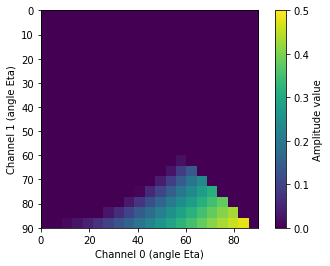

In [31]:
Ref = []
for eta_pair in theoric_result['eta_pairs']:
    Ref.append((eta_pair[1]))
    Ref.append((eta_pair[0]))
Ref = sorted(list(dict.fromkeys(Ref)))
lenRef = len(Ref)
ampRef = np.zeros((lenRef,lenRef))
valuesRef = list(theoric_result.values())
for ind_prob in range(len(valuesRef[3])):
    ind_0 = Ref.index(theoric_result['eta_pairs'][ind_prob][0])
    ind_1 = Ref.index(theoric_result['eta_pairs'][ind_prob][1])
    ampRef[ind_1, ind_0]= valuesRef[3][ind_prob]

fig = plt.figure('Input state amplitude |1> expected from theory')
ax1 = fig.add_subplot(111)
im = ax1.imshow(ampRef, cmap='viridis', extent =(0, 90, 90, 0), vmin=0, vmax=0.5)
cb = plt.colorbar(im, label = 'Amplitude value')
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

plt.show()

## Amplitude deltas when comparing simulation results from theory

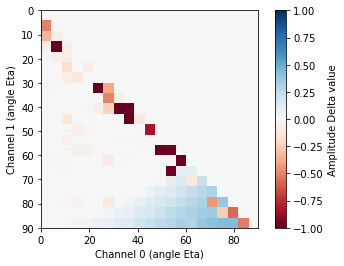

In [32]:
Deltaamp1= ampRef - amp1

fig = plt.figure('Difference in Amplitudes (simulation1 vs. theory')
ax1 = fig.add_subplot(111)
im = ax1.imshow(Deltaamp1, cmap='RdBu', extent =(0, 90, 90, 0), vmin=-1, vmax=1)
cb = plt.colorbar(im, label = 'Amplitude Delta value')
ax1.set_xlabel('Channel 0 (angle Eta)')
ax1.set_ylabel('Channel 1 (angle Eta)')

plt.show()

In [33]:
lambdas = np.append(np.arange(0, 1, 0.05), 1)
etas = np.arcsin(np.sqrt(lambdas))
print(etas)

[0.         0.22551341 0.32175055 0.39769942 0.46364761 0.52359878
 0.57963974 0.63305184 0.6847192  0.73531445 0.78539816 0.83548187
 0.88607712 0.93774449 0.99115659 1.04719755 1.10714872 1.17309691
 1.24904577 1.34528292 1.57079633]
